In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download the Dataset for Interencing

In [1]:
# install kaggle
!pip install -q kaggle

In [2]:
# create kaggle folder
!mkdir ~/.kaggle

# copy the kaggle.json to the folder created
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_API_Token/kaggle.json ~/.kaggle/

# permission for the jason to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Loading the dataset using Kaggle API Command
!kaggle datasets download -d chitholian/annotated-potholes-dataset

In [ ]:
# Unzipping the dataset
!unzip /content/annotated-potholes-dataset.zip

# Update OpenCV

In [5]:
!pip install opencv-python -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 1.5 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
import cv2

print('OpenCV version: ', cv2.__version__)

OpenCV version:  4.6.0


# Load the `.onnx` Model with `cv2.dnn` Module

In [7]:
import cv2
import numpy as np

model_onnx_weights_path = '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole/best.onnx'

net = cv2.dnn.readNetFromONNX(model_onnx_weights_path)

# Necessary Functions

In [8]:
INPUT_HEIGHT = 640
INPUT_WIDTH = 640

# preprocess the input and get the model outputs
def pre_process(input_image, net):
    blob = cv2.dnn.blobFromImage(input_image, 1/255,  (INPUT_WIDTH, INPUT_HEIGHT), [0,0,0], swapRB = True , crop=False)
    net.setInput(blob)
    outputs = net.forward(net.getUnconnectedOutLayersNames())
    return outputs

# postprocess the results and return the class ids, confidences & bounding boxes
def post_process(input_image, outputs, conf_thresh = 0.4, score_thresh = 0.4):
    class_ids = []
    confidences = []
    boxes = []

    rows = outputs.shape[0]
    image_height, image_width = input_image.shape[:2]

    x_factor = image_width / INPUT_WIDTH
    y_factor =  image_height / INPUT_HEIGHT

    for r in range(rows):
        row = outputs[r]
        confidence = row[4]

        if confidence >= conf_thresh:
                classes_scores = row[5:]
                class_id = np.argmax(classes_scores)

                if (classes_scores[class_id] > score_thresh):
                    confidences.append(confidence)
                    class_ids.append(class_id)
                    cx, cy, w, h = row[0], row[1], row[2], row[3]
                    left = int((cx - w/2) * x_factor)
                    top = int((cy - h/2) * y_factor)
                    width = int(w * x_factor)
                    height = int(h * y_factor)
                    box = np.array([left, top, width, height])
                    boxes.append(box)
    return class_ids, confidences, boxes

# non max suppression
def non_max_suppression(class_ids, confidences, boxes, conf_thresh = 0.4, nms_thresh = 0.45):
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, conf_thresh, nms_thresh, ) 

    result_class_ids = []
    result_confidences = []
    result_boxes = []

    for i in indexes:
        result_confidences.append(confidences[i])
        result_class_ids.append(class_ids[i])
        result_boxes.append(boxes[i])

    return result_class_ids, result_confidences, result_boxes

# Custom Visualization Functions

In [10]:
import cv2

def draw_focused_rectangle(image, bbox, color, corner_length = 30, corner_thickness = 4, edge_thickness = 1):
    img = image.copy()

    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if (x1+corner_length > x2) or (y1+corner_length > y2):
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
        # top left corner
        cv2.line(img, (x1, y1), (x1+corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y1), (x1, y1+corner_length), color = color, thickness = corner_thickness)
        # top right corner
        cv2.line(img, (x2, y1), (x2-corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y1), (x2, y1+corner_length), color = color, thickness = corner_thickness)
        # bottom left corner
        cv2.line(img, (x1, y2), (x1+corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y2), (x1, y2-corner_length), color = color, thickness = corner_thickness)
        # bottom right corner
        cv2.line(img, (x2, y2), (x2-corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y2), (x2, y2-corner_length), color = color, thickness = corner_thickness)

    return img

def draw_label(image, label, x, y, box_color, font_color, font_face = cv2.FONT_HERSHEY_SIMPLEX, font_scale = .75):
    img = image.copy()

    text_size = cv2.getTextSize(label, fontFace=font_face, fontScale=font_scale, thickness=2)
    dim, baseline = text_size[0], text_size[1]
    
    # cv2.rectangle(img, (x,y), (x + dim[0], y + dim[1] + baseline), box_color, cv2.FILLED);
    # cv2.putText(img, label, (x, y + dim[1] + 2), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    cv2.rectangle(img, (x, y - dim[1] - baseline), (x + dim[0], y), box_color, cv2.FILLED);
    cv2.putText(img, label, (x, y - dim[1] + 10), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=2)

    return img

# Custom Detection Function

In [11]:
def detect_image(image, net, detection_threshold, classes, colors):
    outputs = np.array(pre_process(image, net))[0][0]
    all_class_ids, all_confidences, all_boxes = post_process(image, outputs, conf_thresh = detection_threshold)
    class_ids, confidences, boxes = non_max_suppression(all_class_ids, all_confidences, all_boxes, conf_thresh = detection_threshold)

    if len(class_ids) == 0:
        return image

    for i in range(len(class_ids)):
        cls_id = class_ids[i]
        cls = classes[cls_id]
        conf = int(confidences[i]*100)
        color = colors[cls]
        label = f'{cls}: {conf}%'
        
        xmin = boxes[i][0]
        ymin = boxes[i][1]
        xmax = xmin + boxes[i][2]
        ymax = ymin + boxes[i][3]

        image = draw_focused_rectangle(image, (xmin, ymin, xmax, ymax), color)
        image = draw_label(image, label, xmin, ymin, color, (255,255,255))

    return image

# Define the classes and their colors

In [9]:
classes = {0: 'pothole'}
colors = {'pothole': (0,50,255)} #BGR

# Do Detections

In [59]:
import os
import random

# Take a random image from the dataset
DATA_SOURCE_PATH = '/content/annotated-images'
IMAGES_PATHS = [DATA_SOURCE_PATH + '/' + fil for fil in os.listdir(DATA_SOURCE_PATH) if os.path.splitext(fil)[1] == '.jpg']
SAMPLE_IMAGE_PATH = random.sample(IMAGES_PATHS, 1)[0]
print(os.path.basename(SAMPLE_IMAGE_PATH))

img-20.jpg


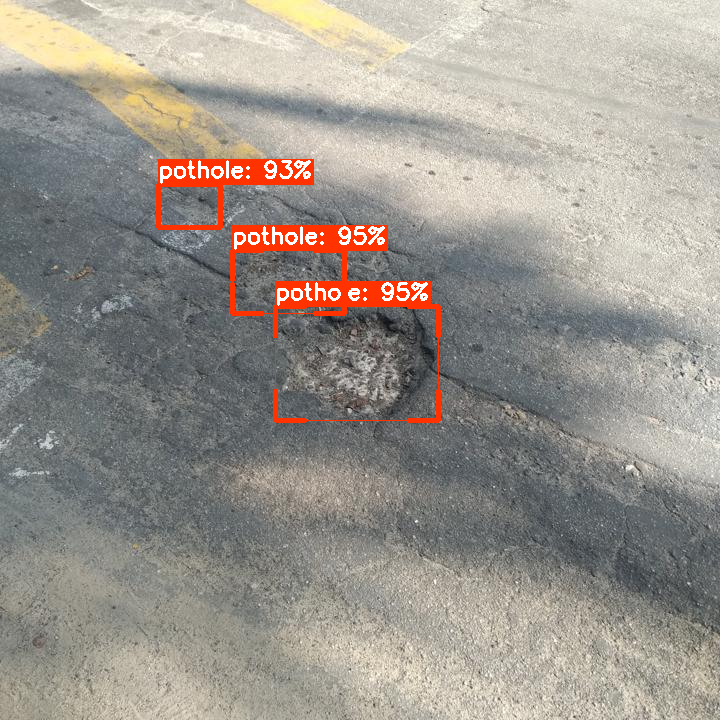

In [60]:
from google.colab.patches import cv2_imshow

# Detection on the randomly selected image
image = cv2.imread(SAMPLE_IMAGE_PATH)
detected_image = detect_image(image, net, 0.4, classes, colors)

cv2_imshow(detected_image)